In [2]:
import pandas as pd

dataset = pd.read_csv('arquivos/supermarket_sales.csv')
dataset.head(5)

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


In [23]:
dataset['Rating'].mean()

6.9727

In [4]:
import openai
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())

client = openai.Client()

## Cria o assistant

In [5]:
file = client.files.create(
    file=open('arquivos/supermarket_sales.csv', 'rb'),
    purpose='assistants'
)

In [7]:
assitant = client.beta.assistants.create(
    name="Analista Fianceiro",
    instructions='Você é um analista financeiro de um supermercado. Você deve utilizar os dados \
        .csv informados relativos as vendas do supermercado para realizar as suas análises.',
    tools=[{'type': 'code_interpreter'}],
    tool_resources={'code_interpreter': {'file_ids': [file.id]}},
    model='gpt-4o'
)

## Cria uma thread

In [8]:
thread = client.beta.threads.create()

## Adiciona mensagem a thread criada

In [27]:
texto_mensagem = 'Qual é o raqting médio das vendas do supermercado? O arquivo estáno formato csv.'
texto_mensagem = 'Gere um gráfico de pizza com o percentual de vendas por meio de pagamento. O arquivo está no formato csv.'

message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role='user',
    content=texto_mensagem
)

## Roda a thread no assistant

In [28]:
run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assitant.id,
    instructions='O nome do usuário é Adriano Soares e ele é um usuário Premium.'
)

## Aguarda a thread rodar

In [29]:
import time

while run.status in ['queued', 'in_progress', 'cancelling']:
    time.sleep(1)
    run = client.beta.threads.runs.retrieve(
        thread_id=thread.id,
        run_id=run.id
    )


In [30]:
run.status

'completed'

## Verifica a resposta

In [31]:
if run.status == 'completed':
    mensagens = client.beta.threads.messages.list(
        thread_id=thread.id
    )
    print(mensagens)
else:
    print('Errro', run.status)

SyncCursorPage[Message](data=[Message(id='msg_BBFvWlwUFpZ3rpcpuYkMNoc7', assistant_id='asst_SF4BvXvzf3u71aDnOVoHG4pz', attachments=[], completed_at=None, content=[ImageFileContentBlock(image_file=ImageFile(file_id='file-XH64csDOSLd96hj7OrLN3CTe'), type='image_file'), TextContentBlock(text=Text(annotations=[], value='Aqui está o gráfico de pizza mostrando o percentual de vendas por meio de pagamento. As vendas estão distribuídas entre:\n\n- **Ewallet**: 34.5%\n- **Cash**: 34.4%\n- **Credit card**: 31.1%\n\nSe precisar de mais alguma coisa, estou à disposição!'), type='text')], created_at=1716990750, incomplete_at=None, incomplete_details=None, metadata={}, object='thread.message', role='assistant', run_id='run_6ytzk2zxnvCjNBGJlfdzTzo8', status=None, thread_id='thread_IV1J6CYkpxuFThgeWe3zppTB'), Message(id='msg_B88lhP86HlZ6AhY1JwG9YgMk', assistant_id=None, attachments=[], completed_at=None, content=[TextContentBlock(text=Text(annotations=[], value='Gere um gráfico de pizza com o percentu

In [33]:
print(mensagens.data[0].content[0])

ImageFileContentBlock(image_file=ImageFile(file_id='file-XH64csDOSLd96hj7OrLN3CTe'), type='image_file')


## Analisando os passos do modelo

In [34]:
run_steps = client.beta.threads.runs.steps.list(
  thread_id=thread.id,
  run_id=run.id
)


=== Step: tool_calls
-----
import matplotlib.pyplot as plt

# Contagem do número de vendas por meio de pagamento
pagamento_counts = data_csv['Payment'].value_counts()

# Percentual de vendas por meio de pagamento
pagamento_percent = pagamento_counts / pagamento_counts.sum() * 100

# Plotar o gráfico de pizza
plt.figure(figsize=(8, 8))
plt.pie(pagamento_percent, labels=pagamento_percent.index, autopct='%1.1f%%', startangle=140, colors=['gold', 'lightblue', 'lightcoral'])
plt.title('Percentual de Vendas por Meio de Pagamento')
plt.show()
-----
Result

=== Step: message_creation
Imagem file-XH64csDOSLd96hj7OrLN3CTe salva


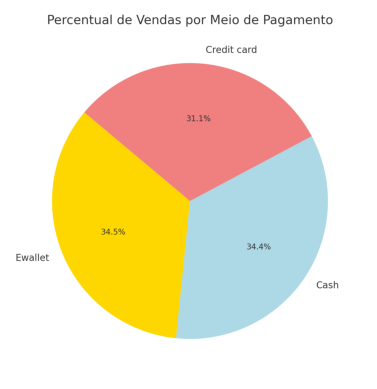

In [39]:
for step in run_steps.data[::-1]:
    print('\n=== Step:', step.step_details.type)
    if step.step_details.type == 'tool_calls':
        for tool_call in step.step_details.tool_calls:
            print('-----')
            print(tool_call.code_interpreter.input)
            print('-----')
            print('Result')
            if tool_call.code_interpreter.outputs[0].type == 'logs':
                print(tool_call.code_interpreter.outputs[0].logs)
    if step.step_details.type == 'message_creation':
        message = client.beta.threads.messages.retrieve(
            thread_id=thread.id,
            message_id=step.step_details.message_creation.message_id
        )
        if message.content[0].type == 'text':
            print(message.content[0].text.value)
        
        if message.content[0].type == 'image_file':
            file_id = message.content[0].image_file.file_id
            image_data = client.files.content(file_id)
            with open(f'arquivos/{file_id}.png', 'wb') as f:
                f.write(image_data.read())
                print(f'Imagem {file_id} salva')
            
            import matplotlib.pyplot as plt
            import matplotlib.image as mpimg

            img = mpimg.imread(f'arquivos/{file_id}.png')
            fig, ax = plt.subplots()
            ax.set_axis_off()
            ax.imshow(img)
            plt.show()
    